In [46]:
import os
import glob

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

In [2]:
path = 'data/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_from_file = (pd.read_csv(f) for f in csv_files)
df_football = pd.concat(df_from_file, ignore_index = True)

df_football.Date = pd.to_datetime(df_football.Date)
# df_football = df_football.set_index('Date')

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,SBH,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH
0,2,18,0,6,3,1,Alaves,4.10,3.20,2.05,...,NaN,NaN,NaN,NaN,4.40,3.2,2.05,4.00,3.10,2.05
1,2,13,1,5,4,3,Las Palmas,4.50,3.80,1.75,...,NaN,NaN,NaN,NaN,4.60,4.0,1.80,4.20,3.75,1.80
2,4,11,0,13,6,1,Sociedad,3.20,3.25,2.38,...,NaN,NaN,NaN,NaN,3.13,3.4,2.40,2.90,3.40,2.40
3,0,15,1,9,3,4,Ath Madrid,1.45,4.33,8.00,...,NaN,NaN,NaN,NaN,1.50,4.3,7.50,1.44,4.20,8.00
4,3,12,0,9,6,4,Espanol,5.50,4.00,1.62,...,NaN,NaN,NaN,NaN,5.75,4.0,1.65,5.50,3.60,1.67


In [3]:
df_football.shape

(2459, 76)

In [4]:
ftr_dummies = pd.get_dummies(df_football.FTR, prefix='FTR')
df_football = pd.concat([df_football, ftr_dummies], axis = 1)

htr_dummies = pd.get_dummies(df_football.HTR, prefix='HTR')
df_football = pd.concat([df_football, htr_dummies], axis = 1)

df_football.head()

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,...,VCH,WHA,WHD,WHH,FTR_A,FTR_D,FTR_H,HTR_A,HTR_D,HTR_H
0,2,18,0,6,3,1,Alaves,4.10,3.20,2.05,...,2.05,4.00,3.10,2.05,0,0,1,0,0,1
1,2,13,1,5,4,3,Las Palmas,4.50,3.80,1.75,...,1.80,4.20,3.75,1.80,0,0,1,0,0,1
2,4,11,0,13,6,1,Sociedad,3.20,3.25,2.38,...,2.40,2.90,3.40,2.40,1,0,0,0,1,0
3,0,15,1,9,3,4,Ath Madrid,1.45,4.33,8.00,...,7.50,1.44,4.20,8.00,0,1,0,0,0,1
4,3,12,0,9,6,4,Espanol,5.50,4.00,1.62,...,1.65,5.50,3.60,1.67,0,1,0,0,1,0


# Eligiendo la variable a predecir

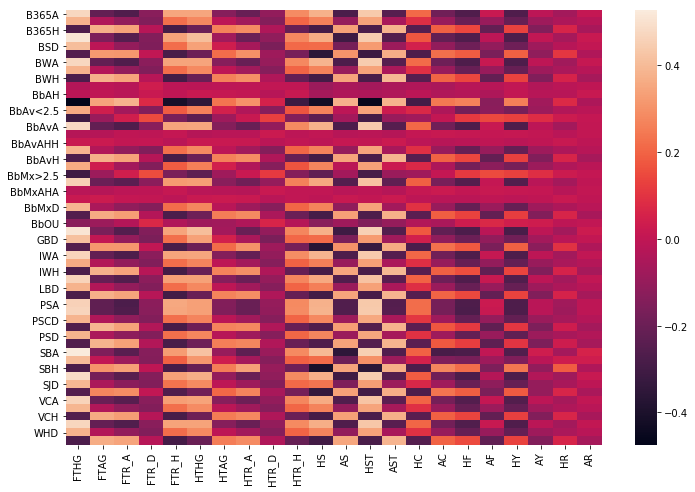

In [47]:
features_to_predict = ['FTHG', 'FTAG', 'FTR_A', 'FTR_D', 'FTR_H', 
                       'HTHG', 'HTAG', 'HTR_A', 'HTR_D', 'HTR_H', 
                       'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 
                       'AF', 'HY', 'AY', 'HR', 'AR']

df_corr = df_football.corr().filter(features_to_predict).drop(features_to_predict)

sns.heatmap(df_corr)

In [6]:
final_features_to_predict = [feat for feat in features_to_predict 
                            if len(df_corr[df_corr.abs()[feat] > 0.5]) > 0]
final_features_to_predict

['FTHG']

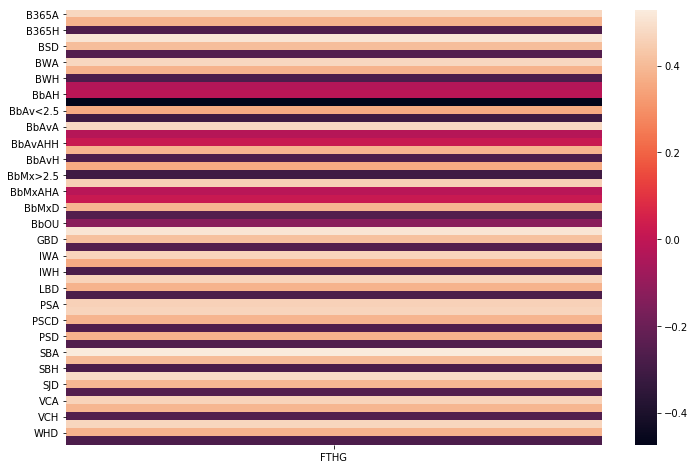

In [48]:
 sns.heatmap(df_corr[['FTHG']])

In [8]:
df = df_football[df_corr[['FTHG']].index]
df = pd.concat([df, df_football['FTHG']], axis=1)

df.head()

,B365A,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,...,SJA,SJD,SJH,VCA,VCD,VCH,WHA,WHD,WHH,FTHG
0,4.10,3.20,2.05,NaN,NaN,NaN,4.10,3.10,2.05,35,...,NaN,NaN,NaN,4.40,3.2,2.05,4.00,3.10,2.05,1
1,4.50,3.80,1.75,NaN,NaN,NaN,4.60,3.90,1.75,35,...,NaN,NaN,NaN,4.60,4.0,1.80,4.20,3.75,1.80,1
2,3.20,3.25,2.38,NaN,NaN,NaN,3.00,3.30,2.40,35,...,NaN,NaN,NaN,3.13,3.4,2.40,2.90,3.40,2.40,2
3,1.45,4.33,8.00,NaN,NaN,NaN,1.45,4.33,7.50,35,...,NaN,NaN,NaN,1.50,4.3,7.50,1.44,4.20,8.00,2
4,5.50,4.00,1.62,NaN,NaN,NaN,5.75,3.90,1.62,35,...,NaN,NaN,NaN,5.75,4.0,1.65,5.50,3.60,1.67,1


Text(0.5,0,'percentage')

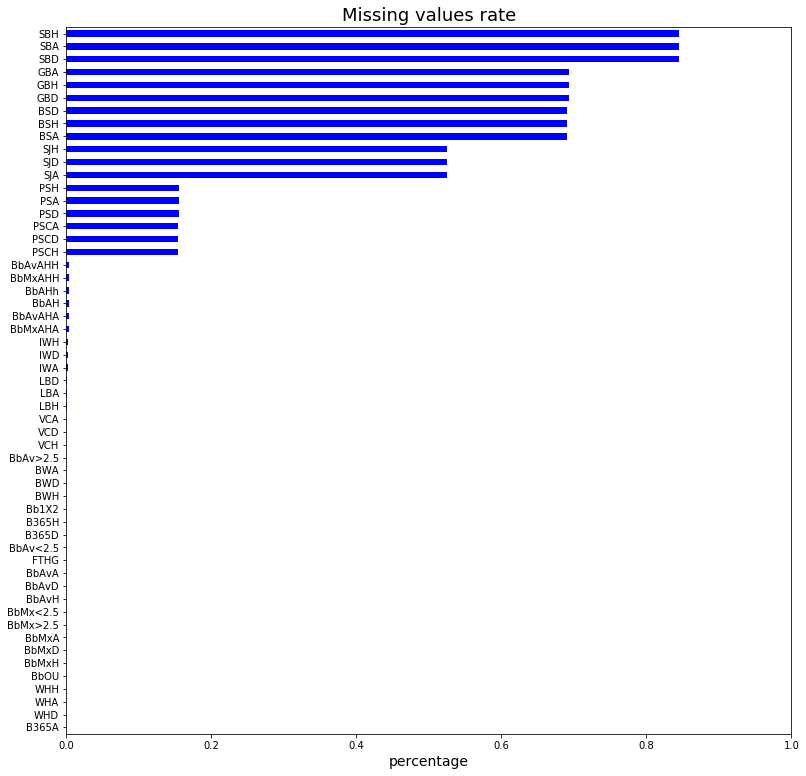

In [9]:
null_data = df.isnull().mean()

plt.figure(figsize = (13, 13))
null_data.sort_values().plot.barh(color = 'blue')
plt.xlim(xmax = 1)
plt.title("Missing values rate", fontsize = 18)
plt.xlabel("percentage", fontsize = 14)

In [10]:
features_wanted = null_data[null_data < 0.3].index
    
df = df[features_wanted]
df = df.fillna(round(df.mean(), 2))

df.head()

,B365A,B365D,B365H,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,...,PSCH,PSD,PSH,VCA,VCD,VCH,WHA,WHD,WHH,FTHG
0,4.10,3.20,2.05,4.10,3.10,2.05,35,18.0,-0.50,1.46,...,1.98,3.25,2.03,4.40,3.2,2.05,4.00,3.10,2.05,1
1,4.50,3.80,1.75,4.60,3.90,1.75,35,16.0,-0.75,2.27,...,1.78,4.01,1.78,4.60,4.0,1.80,4.20,3.75,1.80,1
2,3.20,3.25,2.38,3.00,3.30,2.40,35,18.0,-0.25,1.84,...,2.12,3.40,2.44,3.13,3.4,2.40,2.90,3.40,2.40,2
3,1.45,4.33,8.00,1.45,4.33,7.50,35,16.0,1.25,1.74,...,6.93,4.38,8.36,1.50,4.3,7.50,1.44,4.20,8.00,2
4,5.50,4.00,1.62,5.75,3.90,1.62,35,16.0,-1.00,2.09,...,1.64,4.17,1.62,5.75,4.0,1.65,5.50,3.60,1.67,1


In [11]:
df.shape

(2459, 43)

# Separación de datos de entrenamiento y test

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_X = df.copy()
df_y = df_X['FTHG']
del df_X['FTHG']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.25, random_state = 42)

In [14]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (1844, 42)
X_test:  (615, 42)
y_train: (1844,)
y_test:  (615,)


# Regresión lineal básica

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
reg_LR = LinearRegression()
reg_LR_fit = reg_LR.fit(X_train, y_train)
y_pred_LR = reg_LR.predict(X_test)

In [45]:
print('Intercept: ', reg_LR.intercept_)
print('Coefficients:')
list(zip(df_X.columns, reg_LR.coef_))

Intercept:  3.18168463497
Coefficients:


[('B365A', 0.055023210955761799),
 ('B365D', -0.1220275852920242),
 ('B365H', 0.14429220003794793),
 ('BWA', -0.013737964447231344),
 ('BWD', 0.18488246804921346),
 ('BWH', -0.077100123970756537),
 ('Bb1X2', 0.0038557379426815905),
 ('BbAH', -0.00036734531480440486),
 ('BbAHh', -0.30391759973875715),
 ('BbAv<2.5', 0.34289358193473346),
 ('BbAv>2.5', -0.32692620131051547),
 ('BbAvA', 0.29621471909746022),
 ('BbAvAHA', -1.048841909359127),
 ('BbAvAHH', 0.47428236019077752),
 ('BbAvD', -0.10273295504223555),
 ('BbAvH', -0.059265601371871333),
 ('BbMx<2.5', -0.12809005953891534),
 ('BbMx>2.5', -0.14639904225829478),
 ('BbMxA', -0.099209664681106993),
 ('BbMxAHA', 0.72078907517232582),
 ('BbMxAHH', -0.54756589017241808),
 ('BbMxD', 0.11563775126709676),
 ('BbMxH', -0.067157786672627798),
 ('BbOU', -0.013787222092873473),
 ('IWA', -0.050703970710237932),
 ('IWD', -0.041391824653440601),
 ('IWH', -0.0058787786453809937),
 ('LBA', -0.014652755684059108),
 ('LBD', 0.031691671068310348),
 ('LBH'

In [18]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))

Mean squared error: 1.46
Variance score: 0.22


# Lasso

In [26]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV

### Lasso CV para conocer alpha

In [28]:
alphas = np.logspace(-4, -0.5, 30)
alphas

array([  1.00000000e-04,   1.32035178e-04,   1.74332882e-04,
         2.30180731e-04,   3.03919538e-04,   4.01280703e-04,
         5.29831691e-04,   6.99564216e-04,   9.23670857e-04,
         1.21957046e-03,   1.61026203e-03,   2.12611233e-03,
         2.80721620e-03,   3.70651291e-03,   4.89390092e-03,
         6.46167079e-03,   8.53167852e-03,   1.12648169e-02,
         1.48735211e-02,   1.96382800e-02,   2.59294380e-02,
         3.42359796e-02,   4.52035366e-02,   5.96845700e-02,
         7.88046282e-02,   1.04049831e-01,   1.37382380e-01,
         1.81393069e-01,   2.39502662e-01,   3.16227766e-01])

In [20]:
lasso_CV = LassoCV(cv=10, n_jobs=-1, normalize=True, alphas=alphas)
lasso_CV.fit(df_X, df_y)

best_alpha_lasso_CV = lasso_CV.alpha_

print('Score: \n', lasso_CV.score(df_X, df_y))
print('Alpha: \n', lasso_CV.alpha_)
print('CV: \n', lasso_CV.coef_)

Score: 
 0.266433968783
Alpha: 
 0.000303919538231
CV: 
 [ 0.00834239  0.         -0.          0.00196368  0.         -0.         -0.
 -0.         -0.40195062  0.0731298  -0.50996469  0.          0.         -0.
  0.         -0.          0.         -0.0314552   0.          0.         -0.
  0.01347157 -0.00778044 -0.00487348  0.         -0.         -0.          0.
  0.         -0.01611084 -0.          0.          0.         -0.00237007
 -0.         -0.          0.00951423  0.         -0.          0.          0.
 -0.        ]


In [21]:
lasso = Lasso(normalize=True, alpha=best_alpha_lasso_CV)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Mean squared error: 1.40
Variance score: 0.25


### Lasso con cross_val_predict

In [22]:
cv_outer = KFold(len(df_X), n_folds = 10)

lasso = LassoCV(cv = 10, n_jobs = -1, normalize=True, alphas=alphas)
# lasso = Lasso(normalize=True)

# scores = cross_val_score(lasso, df_X, df_y, cv=cv_outer)

predicted = cross_val_predict(lasso, df_X, df_y, cv=cv_outer)

print("Mean squared error: %.2f" % mean_squared_error(df_y, predicted))
print('Variance score: %.2f' % r2_score(df_y, predicted))

Mean squared error: 1.51
Variance score: 0.25


### Lasso con GridSearchCV

In [30]:
lasso = Lasso(normalize=True)

tuned_parameters = [{'alpha': alphas}]
n_folds = 10

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds)
clf.fit(df_X, df_y)

best_alpha_lasso_GS = clf.best_params_['alpha']
best_alpha_lasso_GS

0.00052983169062837071

In [31]:
from sklearn.linear_model import Lasso

lasso = Lasso(normalize=True, alpha=best_alpha_lasso_GS)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lasso))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Mean squared error: 1.40
Variance score: 0.25


In [42]:
list(zip(df_X.columns, lasso.coef_))

[('B365A', 0.03309653032350663),
 ('B365D', 0.0),
 ('B365H', -0.0),
 ('BWA', 0.0),
 ('BWD', 0.0),
 ('BWH', -0.0078378204638777094),
 ('Bb1X2', -0.0),
 ('BbAH', 0.0),
 ('BbAHh', -0.41431838542393346),
 ('BbAv<2.5', 0.0047456305424997394),
 ('BbAv>2.5', -0.45726881391555602),
 ('BbAvA', 0.0),
 ('BbAvAHA', -0.0),
 ('BbAvAHH', 0.0),
 ('BbAvD', 0.0),
 ('BbAvH', -0.0),
 ('BbMx<2.5', 0.0),
 ('BbMx>2.5', -0.077497316683644651),
 ('BbMxA', 0.0),
 ('BbMxAHA', 0.0),
 ('BbMxAHH', -0.0),
 ('BbMxD', 0.0024704863627138399),
 ('BbMxH', -0.0),
 ('BbOU', -0.0051072116394867964),
 ('IWA', 0.0),
 ('IWD', 0.0),
 ('IWH', -0.0),
 ('LBA', 0.0),
 ('LBD', 0.0),
 ('LBH', -0.0030341353130640524),
 ('PSA', -0.0),
 ('PSCA', 0.0),
 ('PSCD', 0.0),
 ('PSCH', -0.0),
 ('PSD', 0.0),
 ('PSH', -0.0),
 ('VCA', 0.0),
 ('VCD', 0.0),
 ('VCH', -0.0),
 ('WHA', 0.0),
 ('WHD', 0.0),
 ('WHH', -0.0)]